## Vmax tracking using IBTrACS

TODO: 

- Asymmetry information?

- IBTrACS or EBTRK? ==> JTWC Best-Tracks

- Latent parameter?

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'input_size':  len(input_variables),
          'output_size': len(target_variable),
          'seq_len':     360,  
          
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,     # dropout probability
    
          'batch_size':  1,     
          'n_epochs':    50,     # nb of epochs
          'learn_rate':  0.001,  # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/rmax_seq_pred_ibtracs/lstmv02.pth', 
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
# ds_ibt_raw.isel(storm=25)['usa_rmw']

In [6]:
# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852


### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (1): ", len(ds_ibt['storm']))

### 2) FINAL DATASET
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (2): ", len(ds_ibt['storm']))                

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1163.36it/s]


Total samples after (1):  143


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 796.40it/s]

Total samples after (2):  110


In [7]:
final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    f     = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at lat° latitude and assuming it's constant 
    return f

def create_Xt_1_and_Xt(ds_ibt):
    Xt_1 = [] # shape (n_samples, n_features)
    Xt   = [] # shape (n_samples, n_targets)
    
    # For each storm, build Xt_1 and Xt dataset.
    for s in tqdm(range(len(ds_ibt.storm))):
        # Select storm
        ds = ds_ibt.isel(storm=s)
        # Add derivatives
        for p in ['usa_rmw', 'usa_r34', 'usa_wind']:
            ds['{}_diff'.format(p)]     = ds[p] * np.nan
            ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
        # Add Coriolis
        ds['fcor'] = coriolis(np.abs(ds['usa_lat']))
        # Get only valid stime steps
        ds         = ds.dropna(dim='date_time', subset=params_of_interest + ['usa_rmw_diff', 'usa_r34_diff', 'usa_wind_diff'])

        # Add to X and Y dataset
        final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']
        da           = ds[final_params].to_array().transpose()
        # print(da)
        for t in range(len(da['date_time']) - 1):
            Xt_1.append(da[t, :].values)
            Xt.append(da[t + 1, :].values)
        # print(Xt)
    
    # Convert to arrays
    Xt_1 = np.array(Xt_1)
    Xt   = np.array(Xt)
    
    return Xt, Xt_1

def normalize(Xt, Xt_1):
    mu_Xt_1 = np.mean(Xt_1, axis=0)  
    sg_Xt_1 = np.std(Xt_1, axis=0)
    mu_Xt   = np.mean(Xt, axis=0)
    sg_Xt   = np.std(Xt, axis=0)

    Xt_1    = (Xt_1 - mu_Xt_1) / sg_Xt_1
    Xt      = (Xt   - mu_Xt)   / sg_Xt
    return Xt_1, Xt, mu_Xt_1, sg_Xt_1, mu_Xt, sg_Xt

def unNormalize(X, mu, sg):
    return (sg * X) + mu

def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))
    
# Create dataset
Xt, Xt_1 = create_Xt_1_and_Xt(ds_ibt)
    
# Normalize
Xt_1, Xt, mu_Xt_1, sg_Xt_1, mu_Xt, sg_Xt = normalize(Xt, Xt_1)

# Linear model 
from sklearn.linear_model import LinearRegression
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(Xt_1, Xt)
M       = reg_mlr.coef_
print('M = \n' + str(np.around(M, 2)))

# Compute covariance of model
Q = np.cov((Xt - reg_mlr.predict(Xt_1)).T)
print('Q = \n' + str(np.around(Q, 2)))

# UnNormalize
Xt_1 = unNormalize(Xt_1, mu_Xt_1, sg_Xt_1)
Xt   = unNormalize(Xt,   mu_Xt,   sg_Xt)

# Compute covariance of observations
H = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1],
])
R = 0.1 * np.diag(np.nanstd(Xt_1, axis=0))

# # To use covariance
# A       = np.expand_dims(Xt_1, axis=2) # Compute R using dataset
# A_T     = np.transpose(A, (0, 2, 1))
# product = np.einsum('ijk, ikl -> ijl', A, A_T)
# R       = np.nanmean(product, axis=0)

# # To use correlations
# STDs    = np.dot(np.expand_dims(np.nanstd(Xt_1, axis=0), axis=1), np.expand_dims(np.nanstd(Xt_1, axis=0), axis=0))
# R       = np.divide(R, STDs)

100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 38.40it/s]

M = 
[[ 0.98  0.1  -0.    0.    0.    0.   -0.01]
 [-0.13  0.73 -0.03  0.    0.03  0.02 -0.07]
 [-0.02 -0.01  0.93  0.12  0.03  0.01  0.01]
 [-0.1  -0.06 -0.23  0.57  0.11  0.03  0.07]
 [ 0.01  0.01 -0.    0.01  0.98  0.06  0.01]
 [ 0.05  0.06  0.    0.04 -0.08  0.39  0.06]
 [ 0.   -0.   -0.    0.    0.    0.    1.  ]]
Q = 
[[ 0.01  0.06 -0.   -0.01  0.    0.01 -0.  ]
 [ 0.06  0.44 -0.01 -0.04  0.01  0.04 -0.  ]
 [-0.   -0.01  0.03  0.14  0.01  0.04  0.  ]
 [-0.01 -0.04  0.14  0.64  0.02  0.17  0.  ]
 [ 0.    0.01  0.01  0.02  0.02  0.12  0.  ]
 [ 0.01  0.04  0.04  0.17  0.12  0.83  0.  ]
 [-0.   -0.    0.    0.    0.    0.    0.  ]]


In [24]:
# plt.hist(Xt[:, 1], bins=39, density=True)
# plt.grid()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


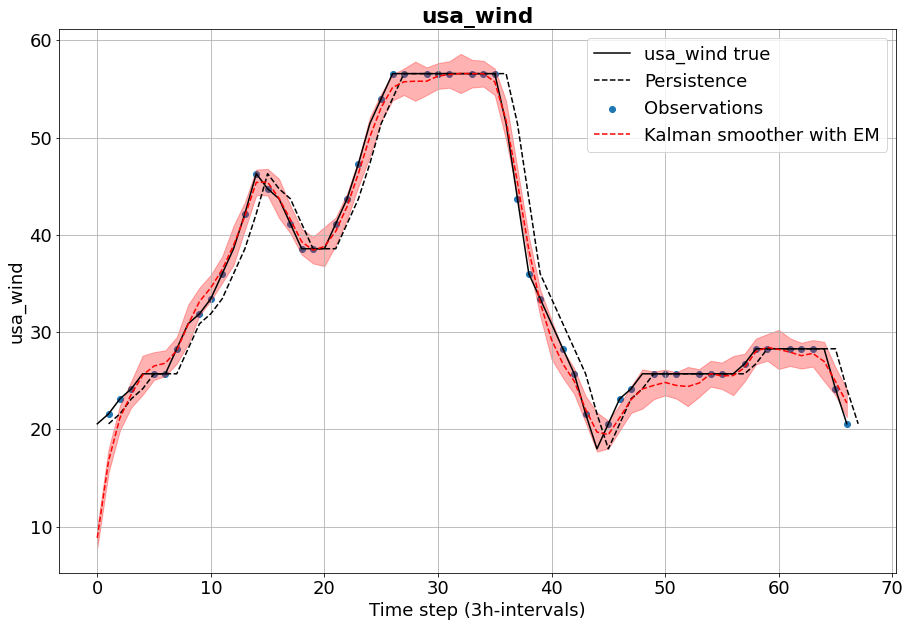

RMSE persistence   = 2.4
RMSE Kalman smooth = 1.8


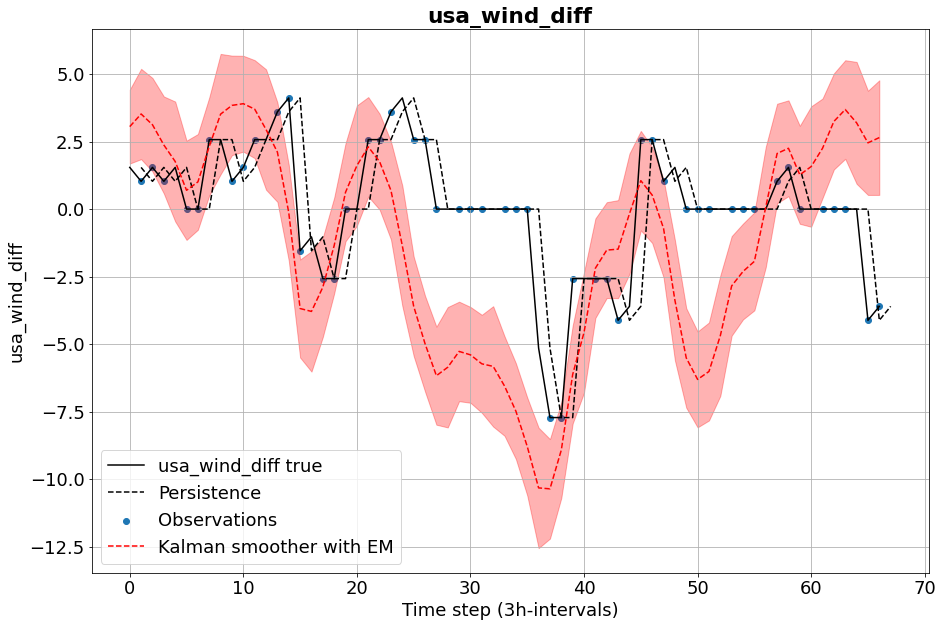

RMSE persistence   = 1.7
RMSE Kalman smooth = 3.8


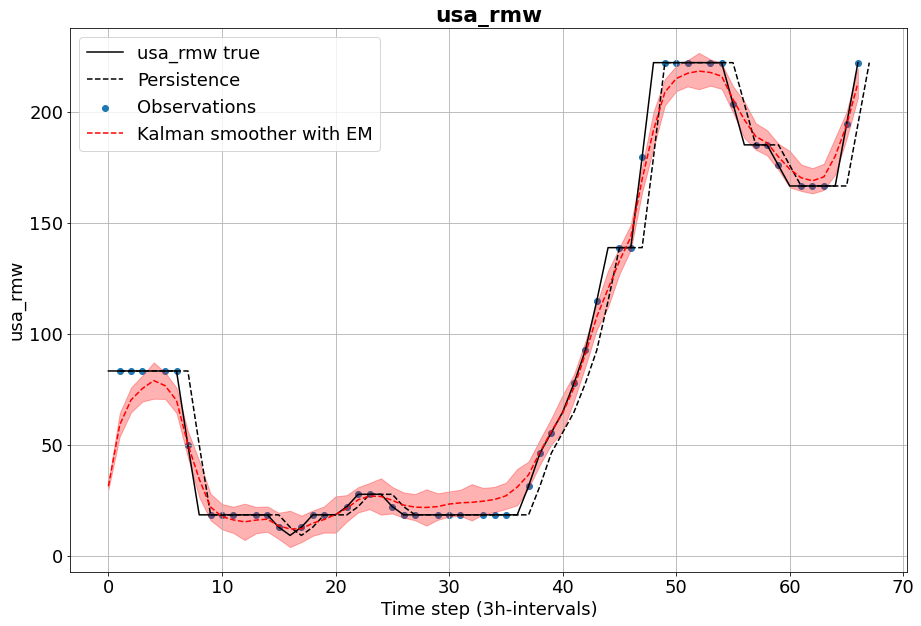

RMSE persistence   = 12.4
RMSE Kalman smooth = 10.2


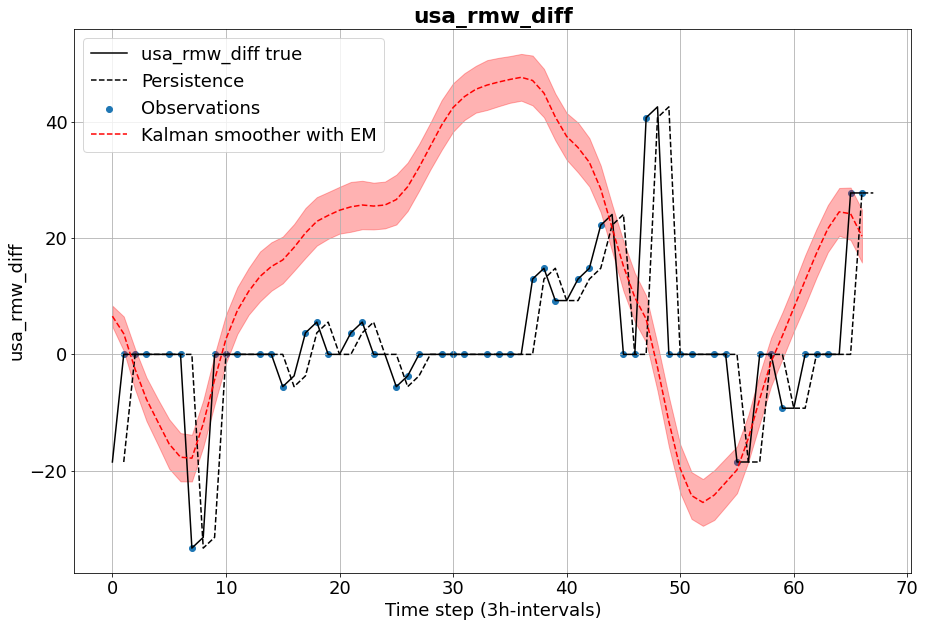

RMSE persistence   = 11.4
RMSE Kalman smooth = 24.9


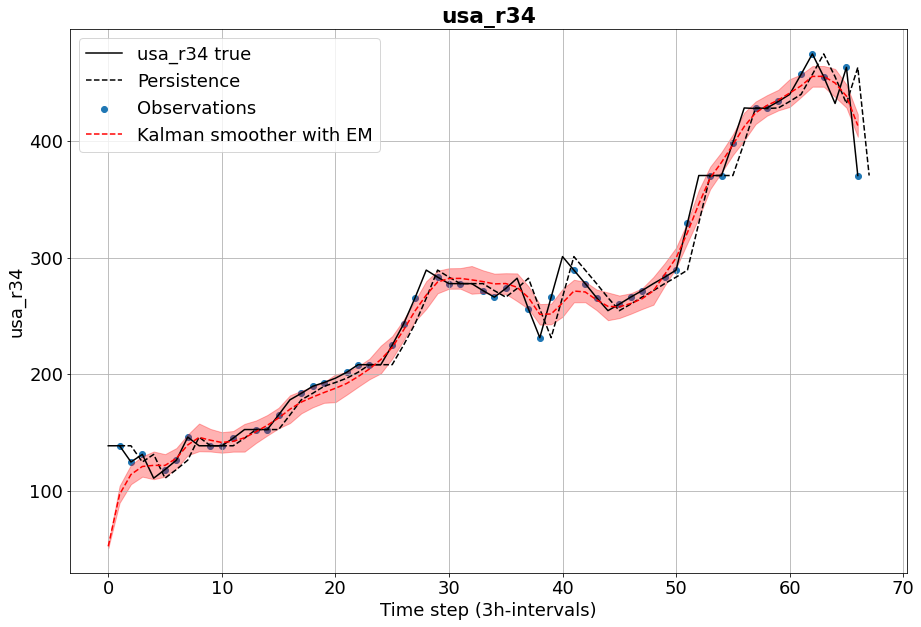

RMSE persistence   = 19.2
RMSE Kalman smooth = 16.6


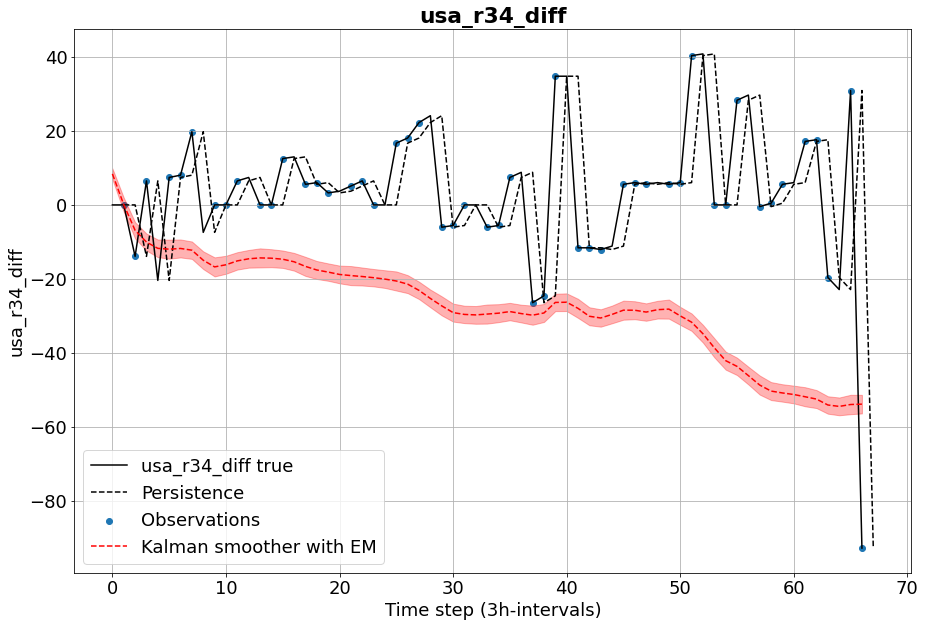

RMSE persistence   = 23.4
RMSE Kalman smooth = 38.0


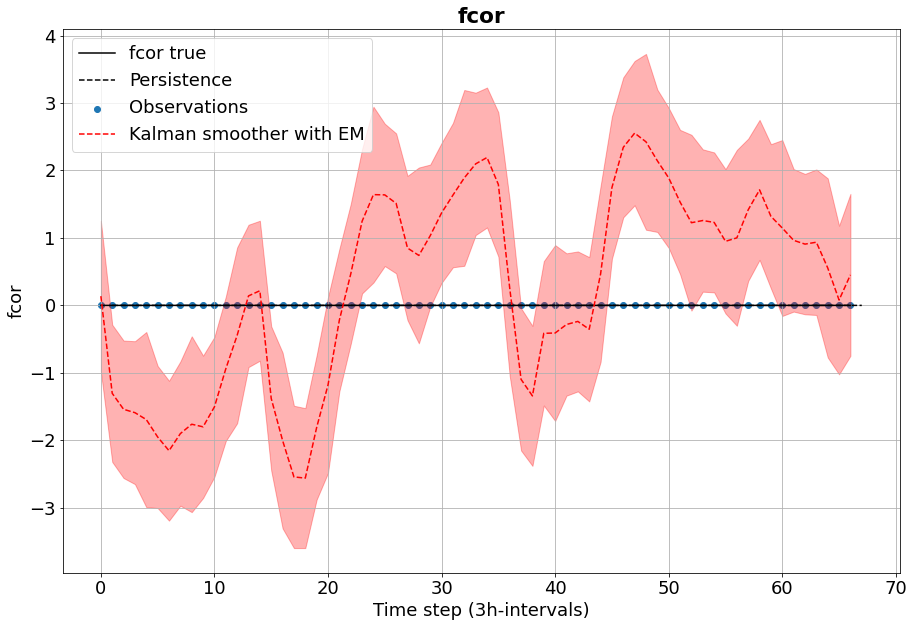

RMSE persistence   = 0.0
RMSE Kalman smooth = 1.4


In [8]:
import copy
### CREATE NOISY OBSERVATIONS
ds0  = ds_ibt.isel(storm=slice(0, 1))
X, _ = create_Xt_1_and_Xt(ds0)
# Create sparse observations
Y            = copy.deepcopy(X)
mask         = np.zeros(X.shape)
mask[::4, :-1] = 1 # Remove every 4th observation, but don't remove fcor
Y            = np.ma.masked_array(Y, mask=mask)

### KALMAN FILTER
# 1) Without EM
kf = KalmanFilter(transition_matrices = M, transition_covariance=Q, observation_matrices = H, observation_covariance=R)
(filtered_state_means, filtered_state_covariances) = kf.filter(Y)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(Y)
# 2) With EM
# kf_em = KalmanFilter(transition_matrices = M, transition_covariance=Q, observation_matrices = H, observation_covariance=R) # Initial conditions for EM
kf_em = KalmanFilter(transition_matrices = M, observation_matrices = H) # KF works better when I don't pass an a priori on Q and R and I let it compute with EM...
# Variables to update with EM
# em_vars = ['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'transition_offsets', 'transition_covariance', 'observation_offsets', 'observation_covariance']
# em_vars = ['initial_state_mean', 'initial_state_covariance', 'transition_covariance', 'observation_covariance']
em_vars = 'all'
# EM step
kf_em = kf_em.em(Y, n_iter=5, em_vars=em_vars)
# Kalman step
(filtered_state_means_em, filtered_state_covariances_em) = kf_em.filter(Y)
(smoothed_state_means_em, smoothed_state_covariances_em) = kf_em.smooth(Y)

# Plot
for i, param in enumerate(final_params):
    plt.title(param, weight='bold')
    plt.plot(X[:, i], c='k', label='{} true'.format(param))
    plt.plot(np.arange(len(X[:, i])) + 1, X[:, i], c='k', label='Persistence', linestyle='--')
    plt.scatter(np.arange(len(X[:, i])), Y[:, i], label='Observations')
    # plt.plot(filtered_state_means[:, i], c='g', label='Kalman filter')
    # plt.plot(smoothed_state_means[:, i], c='g', label='Kalman smoother w/o EM', linestyle='--')
    # plt.plot(filtered_state_means_em[:, i], c='r', label='Kalman filter with EM')
    plt.plot(smoothed_state_means_em[:, i], c='r', label='Kalman smoother with EM', linestyle='--')
    plt.fill_between(np.arange(len(X[:, i])), smoothed_state_means_em[:, i] - 1.96 * np.sqrt(smoothed_state_covariances_em[:, i, i]), smoothed_state_means_em[:, i] + 1.96 * np.sqrt(smoothed_state_covariances_em[:, i, i]), color='r', alpha=0.3)

    plt.ylabel(param)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid();plt.show()

    print('RMSE persistence   = {:.1f}'.format(rmse(X[:-1, i], X[1:, i])))
    print('RMSE Kalman smooth = {:.1f}'.format(rmse(smoothed_state_means_em[:, i], X[:, i])))

In [9]:
R

array([[1.3256544e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.8542004e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.6571326e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0064839e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.2376319e+01, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.7397047e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.0884370e-06]], dtype=float32)

In [10]:
kf_em.observation_covariance

array([[ 7.29663016e-01,  3.26398072e-01, -6.90189094e-01,
        -7.94990967e-01,  2.93052914e+00,  1.19305086e+00,
         1.19579664e-07],
       [ 3.26398072e-01,  1.23537927e+00, -1.58079108e+00,
        -2.92130477e+00,  2.24899750e-01,  3.78801368e+00,
        -6.98153042e-07],
       [-6.90189094e-01, -1.58079108e+00,  1.86556288e+01,
         9.51336528e+00, -6.08925078e+00, -2.07626985e+01,
         2.49829012e-06],
       [-7.94990967e-01, -2.92130477e+00,  9.51336528e+00,
         4.85074545e+01,  5.41703294e+00, -4.13865491e+00,
        -8.91616088e-07],
       [ 2.93052914e+00,  2.24899750e-01, -6.08925078e+00,
         5.41703294e+00,  7.81662643e+01,  9.91847210e+01,
         4.31448913e-06],
       [ 1.19305086e+00,  3.78801368e+00, -2.07626985e+01,
        -4.13865491e+00,  9.91847210e+01,  2.53920260e+02,
         3.77009766e-06],
       [ 1.19579664e-07, -6.98153042e-07,  2.49829012e-06,
        -8.91616088e-07,  4.31448913e-06,  3.77009766e-06,
         1.2300553